### 自作で作ってみる

### 参考サイト：
- データソース：https://www.salesanalytics.co.jp/datascience/datascience097/
- モデル式：https://data-scientist-kasegu.com/2019/08/09/%E5%BA%83%E5%91%8A%E5%8A%B9%E6%9E%9C%E5%AE%9A%E9%87%8F%E5%8C%96%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AEmarketing-mix-modeling-mmm-%E5%85%A5%E9%96%80%E3%81%A8%E5%AE%9F%E8%B7%B53/

In [1]:
# インポート
import numpy as np
import pandas as pd
import pystan
import arviz
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Week       208 non-null    object
 1   Sales      208 non-null    int64 
 2   TVCM       208 non-null    int64 
 3   Newspaper  208 non-null    int64 
 4   Web        208 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.2+ KB
None
        Week    Sales     TVCM  Newspaper     Web
0   2018/1/7  2132000  1312200          0       0
1  2018/1/14  2596100        0     502900  237400
2  2018/1/21  2236200        0     432100  200600
3  2018/1/28  1680900        0     338400       0
4   2018/2/4  2155400        0          0  234000


<AxesSubplot:>

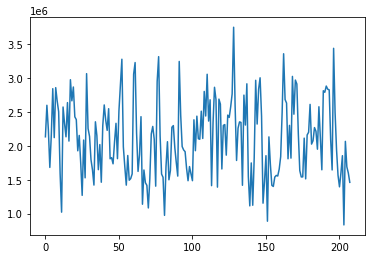

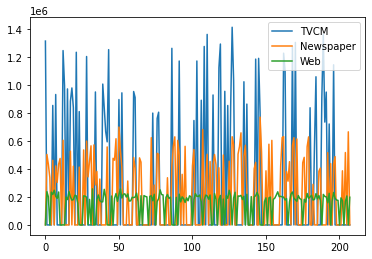

In [2]:
# データ読み込み
df = pd.read_csv('./data/MMM.csv')
print(df.info())
print(df.head())

# 説明変数Xと目的変数yに分解
X = df.drop(columns=['Sales'])
y = df['Sales']
# グラフ化
y.plot()
X.plot()

In [3]:
# Stanで実装
T = df.shape[0]
data = dict(
    T = T,
    T_pred = 3,
    TVCM = df['TVCM'],
    Newspaper = df['Newspaper'],
    Web = df['Web'],
    Y = y
)

stanmodel = pystan.StanModel('./model/model_20220811.stan')
fit = stanmodel.sampling(data=data, 
                         iter=8000, 
                         warmup=4000,
                         control={'max_treedepth': 16}, 
                         thin=6, 
                         seed=1234
                        )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_445cbc4406b1662181a670e0b11d43da NOW.


In [4]:
print(fit)

Inference for Stan model: anon_model_445cbc4406b1662181a670e0b11d43da.
4 chains, each with iter=8000; warmup=4000; thin=6; 
post-warmup draws per chain=667, total post-warmup draws=2668.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]    1.5e6  3123.8  1.5e5  1.2e6  1.4e6  1.5e6  1.6e6  1.8e6   2163    1.0
mu[2]    1.5e6  3279.5  1.3e5  1.2e6  1.4e6  1.5e6  1.6e6  1.7e6   1581    1.0
mu[3]    1.4e6  2480.6  1.2e5  1.2e6  1.3e6  1.4e6  1.5e6  1.7e6   2476    1.0
mu[4]    1.4e6  2397.1  1.2e5  1.2e6  1.3e6  1.4e6  1.5e6  1.6e6   2488    1.0
mu[5]    1.5e6  2941.0  1.2e5  1.2e6  1.4e6  1.5e6  1.5e6  1.7e6   1650    1.0
mu[6]    1.4e6  2559.7  1.2e5  1.2e6  1.3e6  1.4e6  1.5e6  1.7e6   2220    1.0
mu[7]    1.5e6  3099.4  1.2e5  1.2e6  1.4e6  1.5e6  1.5e6  1.7e6   1532    1.0
mu[8]    1.4e6  2712.0  1.2e5  1.2e6  1.4e6  1.4e6  1.5e6  1.7e6   2122    1.0
mu[9]    1.5e6  4455.8  1.3e5  1.3e6  1.4e6  1.5e6  1.6e6  1.8e6    868   1.01
mu[10]   1.4e6  3232.6

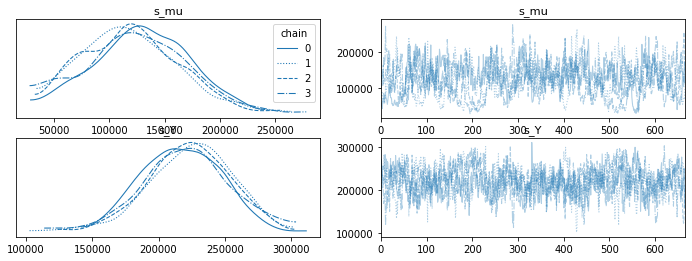

In [5]:
arviz.plot_trace(fit,
                 var_names=['s_mu', 's_Y'],
                 legend=True);

In [16]:
mcmc_result = fit.extract()
mcmc_result['mu'].shape

(2668, 208)

In [48]:
mcmc_result['mu'].shape

(2668, 208)

In [55]:
tmp = mcmc_result['beta_1'].reshape(mcmc_result['beta_1'].shape[0], 1)
np.percentile(tmp, q=[2.5, 50, 97.5])

array([39365.75656341, 46721.16453747, 54790.63887043])

In [62]:
np.median(mcmc_result['beta_1'])

46721.16453746859

In [66]:
# グラフ化
mcmc_result = fit.extract()

# パラメータを指定
state_name = 'mu'

# 2.5・50・97.5パーセンタイルの値を
# 入れるためのデータフレームを作成
result_df = pd.DataFrame(np.zeros([len(df), 3]))

# 2.5・50・97.5パーセンタイルの値をデータフレームに格納
for i in range(len(df)):
    result_df.iloc[i, :] = np.percentile(mcmc_result[state_name][:, i],
                                         q=[2.5, 50, 97.5])

# 列名の変更
result_df.columns = ["mu_lwr", "mu_fit", "mu_upr"]

#beta1_3の中央値を追加
result_df['beta_1'] = np.median(mcmc_result['beta_1'])
result_df['beta_2'] = np.median(mcmc_result['beta_2'])
result_df['beta_3'] = np.median(mcmc_result['beta_3'])

# 時間情報の追加
result_df['time'] = df['Week']

# 実測値を追加
result_df['obs'] =  df['Sales']

In [67]:
result_df

,mu_lwr,mu_fit,mu_upr,beta_1,beta_2,beta_3,time,obs
0,1.198858e+06,1.477360e+06,1.756717e+06,46721.164537,35028.321369,39806.249764,2018/1/7,2132000
1,1.232943e+06,1.478174e+06,1.732168e+06,46721.164537,35028.321369,39806.249764,2018/1/14,2596100
2,1.179534e+06,1.414301e+06,1.660280e+06,46721.164537,35028.321369,39806.249764,2018/1/21,2236200
3,1.159301e+06,1.404319e+06,1.637289e+06,46721.164537,35028.321369,39806.249764,2018/1/28,1680900
4,1.225973e+06,1.453832e+06,1.695352e+06,46721.164537,35028.321369,39806.249764,2018/2/4,2155400
...,...,...,...,...,...,...,...,...
203,7.939965e+05,1.058602e+06,1.303068e+06,46721.164537,35028.321369,39806.249764,2021/11/28,833900
204,8.451872e+05,1.095984e+06,1.323126e+06,46721.164537,35028.321369,39806.249764,2021/12/5,2064700
205,8.777014e+05,1.118078e+06,1.353936e+06,46721.164537,35028.321369,39806.249764,2021/12/12,1689500
206,8.648159e+05,1.102987e+06,1.356822e+06,46721.164537,35028.321369,39806.249764,2021/12/19,1599600


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

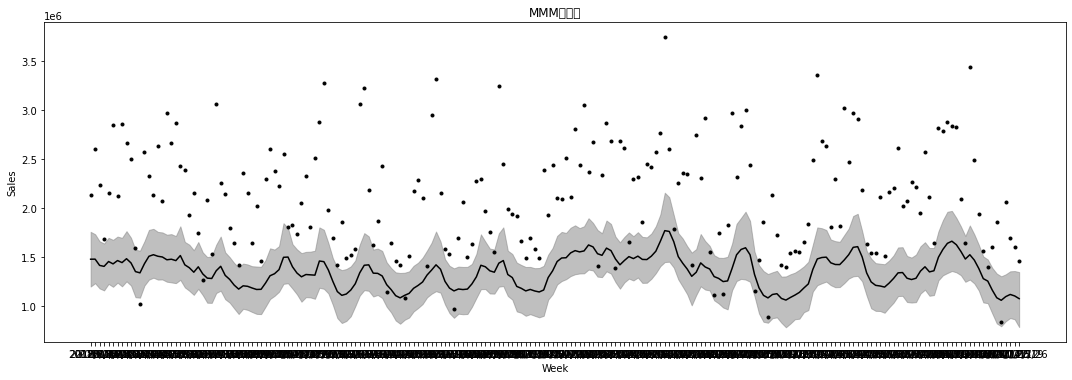

In [39]:
# 描画領域の作成
fig = plt.figure(figsize=(15, 15))

# ローカルレベルモデル
ax_ll = fig.add_subplot(3, 1, 1)
# 実測値をプロット
ax_ll.plot(result_df['time'],
           result_df['obs'],
           marker='.',
           linewidth=0,
           color='black')
# 50パーセンタイルの値をプロット
ax_ll.plot(result_df['time'], result_df['fit'], color='black')
# 2.5-97.5%区間の間を埋める
ax_ll.fill_between(x=result_df['time'],
                   y1=result_df['upr'],
                   y2=result_df['lwr'],
                   color='gray',
                   alpha=0.5)
# x軸ラベルの設定
ax_ll.set_xlabel('Week')
# y軸ラベルの設定
ax_ll.set_ylabel('Sales')
# タイトルの設定
ax_ll.set_title('ローカルレベルモデル')

# x軸ラベルの設定
ax_ll.set_xlabel('Week')
# y軸ラベルの設定
ax_ll.set_ylabel('Sales')
# タイトルの設定
ax_ll.set_title('MMMモデル')

# グラフの描画
fig.tight_layout()
fig.show()